<a href="https://colab.research.google.com/github/gusmendesbh/project4-group2/blob/main/Used_Cars_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
import cufflinks as cf
import plotly
import plotly.express as px


In [2]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.3.1'
spark_version = 'spark-3.3.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Fetched 336 kB in 5s (65.5 kB/s)
Reading package lists... Done


In [3]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder\
    .appName("SparkSQL")\
    .config("spark.sql.debug.maxToStringFields", 2000)\
    .config("spark.driver.memory", "2g")\
    .getOrCreate()

In [4]:
# Read in data from S3 Bucket
from pyspark import SparkFiles
sales_url = "https://car-sales-data-group2.s3.amazonaws.com/vehicles.csv"
spark.sparkContext.addFile(sales_url)
car_sales_df = spark.read.csv(SparkFiles.get("vehicles.csv"), sep=",", header=True)

# Show the sales data.
car_sales_df.show()

+----------+--------------------+--------------------+--------------------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+----+-----+----+----+-----------+---------+-----------+------+-----+----+----+------------+
|        id|                 url|              region|          region_url|price|year|manufacturer|model|condition|cylinders|fuel|odometer|title_status|transmission| VIN|drive|size|type|paint_color|image_url|description|county|state| lat|long|posting_date|
+----------+--------------------+--------------------+--------------------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+----+-----+----+----+-----------+---------+-----------+------+-----+----+----+------------+
|7222695916|https://prescott....|            prescott|https://prescott....| 6000|null|        null| null|     null|     null|null|    null|        null|        null|null| null|null|null|       null|     null|       null|  null|  

In [5]:
car_sales_pandas = car_sales_df.toPandas()

In [6]:
car_sales_pandas.isnull().sum()

id                   0
url               9884
region            6901
region_url        6533
price             6446
year              7890
manufacturer     28937
model            17506
condition       187143
cylinders       190798
fuel             16344
odometer         17801
title_status     21618
transmission     15932
VIN             174486
drive           144178
size            319997
type            106892
paint_color     143839
image_url        13732
description      13733
county          382283
state            23077
lat              25397
long             24715
posting_date     22477
dtype: int64

In [112]:
car_sales_clean = car_sales_pandas.drop(['id', 'url', 'region_url', 'VIN', 'image_url', 'description', 'county', 'lat', 'long', 'posting_date', 'size'], axis=1)

In [113]:
car_sales_clean

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,prescott,6000,None,None,None,None,None,None,None,None,None,None,None,None,az
1,fayetteville,11900,None,None,None,None,None,None,None,None,None,None,None,None,ar
2,florida keys,21000,None,None,None,None,None,None,None,None,None,None,None,None,fl
3,worcester / central MA,1500,None,None,None,None,None,None,None,None,None,None,None,None,ma
4,greensboro,4900,None,None,None,None,None,None,None,None,None,None,None,None,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441797,wyoming,23590,2019,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226,clean,other,fwd,sedan,None,wy
441798,wyoming,30590,2020,volvo,s60 t5 momentum sedan 4d,good,None,gas,12029,clean,other,fwd,sedan,red,wy
441799,wyoming,34990,2020,cadillac,xt4 sport suv 4d,good,None,diesel,4174,clean,other,None,hatchback,white,wy
441800,wyoming,28990,2018,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112,clean,other,fwd,sedan,silver,wy


In [114]:
car_sales_clean.isna().sum()/car_sales_clean.shape[0]*100

region           1.562012
price            1.459025
year             1.785868
manufacturer     6.549767
model            3.962408
condition       42.359021
cylinders       43.186314
fuel             3.699395
odometer         4.029180
title_status     4.893142
transmission     3.606140
drive           32.634076
type            24.194549
paint_color     32.557345
state            5.223381
dtype: float64

In [115]:
car_sales_clean.dropna(subset=['year', 'odometer', 'manufacturer', 'model'])

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
27,auburn,33590,2014,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923,clean,other,None,pickup,white,al
28,auburn,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229,clean,other,None,pickup,blue,al
29,auburn,39590,2020,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160,clean,other,None,pickup,red,al
30,auburn,30990,2017,toyota,tundra double cab sr,good,8 cylinders,gas,41124,clean,other,None,pickup,red,al
31,auburn,15000,2013,ford,f-150 xlt,excellent,6 cylinders,gas,128000,clean,automatic,rwd,truck,black,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441797,wyoming,23590,2019,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226,clean,other,fwd,sedan,None,wy
441798,wyoming,30590,2020,volvo,s60 t5 momentum sedan 4d,good,None,gas,12029,clean,other,fwd,sedan,red,wy
441799,wyoming,34990,2020,cadillac,xt4 sport suv 4d,good,None,diesel,4174,clean,other,None,hatchback,white,wy
441800,wyoming,28990,2018,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112,clean,other,fwd,sedan,silver,wy


In [116]:
# car_sales_clean.fillna('unknown', inplace=True)

In [117]:
car_sales_clean.duplicated().sum()

64429

In [118]:
car_sales_clean = car_sales_clean.drop_duplicates()

In [119]:
car_sales_clean.shape

(377373, 15)

In [120]:
manufacturer_values = car_sales_clean['manufacturer'].value_counts()

In [121]:
print(manufacturer_values)

ford                        61319
chevrolet                   47524
toyota                      29662
honda                       18385
jeep                        16242
                            ...  
2021-04-28T11:07:47-0400        1
2021-04-28T11:07:31-0400        1
2021-04-28T11:07:14-0400        1
2021-04-28T11:06:58-0400        1
2021-05-03T11:06:27-0700        1
Name: manufacturer, Length: 870, dtype: int64


In [122]:
car_sales_clean['model'].value_counts()

f-150                      6589
silverado 1500             4248
1500                       3387
camry                      2561
silverado                  2545
                           ... 
Paige                         1
yukon xl denali 1 owner       1
nx nx 300h                    1
benz 350 clk                  1
Paige Glenbrook Touring       1
Name: model, Length: 30052, dtype: int64

In [123]:
manufacturers_list = ['ford','chevrolet','toyota','honda','jeep','nissan','ram','gmc','bmw','dodge','mercedes-benz','hyundai','volkswagen','subaru','lexus','kia','audi','cadillac','acura','chrysler','buick','mazda','infinity','lincoln','volvo','mitsubishi','mini','pontiac','jaguar','rover','porsche','mercury','saturn','alfa-romeo','tesla','fiat','harley-davidson','ferrari','datsun','aston-martin','land rover']
car_sales_clean_manufacturers = car_sales_clean.loc[car_sales_clean['manufacturer'].isin(manufacturers_list)].copy()

In [124]:
manufacturer_values = car_sales_clean_manufacturers['manufacturer'].value_counts()
print(manufacturer_values)

ford               61319
chevrolet          47524
toyota             29662
honda              18385
jeep               16242
nissan             16129
ram                15624
gmc                14646
bmw                13011
dodge              11508
mercedes-benz      10415
hyundai             8599
volkswagen          8456
subaru              8297
lexus               7261
kia                 7087
audi                6908
cadillac            6069
acura               5538
chrysler            5208
buick               4844
mazda               4788
lincoln             3833
volvo               3023
mitsubishi          2907
mini                2113
pontiac             2064
rover               1864
jaguar              1848
porsche             1210
mercury             1024
saturn               957
alfa-romeo           865
tesla                832
fiat                 708
harley-davidson      133
ferrari               84
datsun                62
aston-martin          22
land rover            21


In [125]:
models_values = car_sales_clean_manufacturers['model'].value_counts()
models_values[0:50]

f-150                 6589
silverado 1500        4248
1500                  3386
camry                 2561
silverado             2543
accord                2494
civic                 2386
escape                2277
2500                  2259
wrangler              2212
altima                2206
explorer              2100
tacoma                2092
grand cherokee        2051
mustang               1907
corolla               1796
equinox               1655
cr-v                  1619
fusion                1601
corvette              1527
focus                 1513
tahoe                 1437
rav4                  1390
malibu                1387
impala                1374
sierra 1500           1371
grand caravan         1362
sonata                1352
silverado 2500hd      1315
outback               1290
3500                  1286
cruze                 1272
odyssey               1263
charger               1259
prius                 1232
f-250                 1224
edge                  1208
j

In [126]:
from ast import mod
model_values = car_sales_clean["model"].value_counts()
filtered_model_values = model_values[model_values > 1]
filtered_model_values
filtered_model_names = filtered_model_values[:51].index
models_to_keep = filtered_model_names.tolist()
models_to_keep.pop(0)
models_to_keep


['silverado 1500',
 '1500',
 'camry',
 'silverado',
 'accord',
 'civic',
 'escape',
 '2500',
 'wrangler',
 'altima',
 'explorer',
 'tacoma',
 'grand cherokee',
 'mustang',
 'corolla',
 'equinox',
 'cr-v',
 'fusion',
 'corvette',
 'focus',
 'tahoe',
 'rav4',
 'malibu',
 'impala',
 'sierra 1500',
 'grand caravan',
 'sonata',
 'silverado 2500hd',
 'outback',
 '3500',
 'cruze',
 'odyssey',
 'charger',
 'prius',
 'f-250',
 'edge',
 'jetta',
 'tundra',
 'elantra',
 'forester',
 'sentra',
 'rogue',
 'sierra',
 'wrangler unlimited',
 'camaro',
 'f150',
 'suburban',
 'pilot',
 '4runner',
 'sienna']

In [127]:
states_list = [ 'ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga',
           'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me',
           'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm',
           'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx',
           'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']

car_sales_clean_manufacturers = car_sales_clean.loc[car_sales_clean['state'].isin(states_list)].copy()


In [128]:
car_sales_clean_manufacturers_models = car_sales_clean_manufacturers.loc[car_sales_clean_manufacturers['model'].isin(models_to_keep)].copy()
car_sales_clean_manufacturers_models

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
28,auburn,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229,clean,other,None,pickup,blue,al
34,auburn,35000,2019,toyota,tacoma,excellent,6 cylinders,gas,43000,clean,automatic,4wd,truck,grey,al
59,auburn,14000,2012,honda,odyssey,excellent,6 cylinders,gas,95000,clean,automatic,fwd,mini-van,silver,al
159,auburn,19000,2017,subaru,forester,like new,4 cylinders,gas,22700,lien,automatic,None,SUV,red,al
170,birmingham,13950,2011,toyota,tacoma,good,4 cylinders,gas,151060,clean,automatic,rwd,truck,silver,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441735,wyoming,1000,1998,ford,explorer,None,6 cylinders,gas,190000,clean,automatic,None,None,None,wy
441770,wyoming,4277,2005,honda,civic,None,None,gas,236787,clean,automatic,None,coupe,None,wy
441773,wyoming,6577,2013,hyundai,elantra,None,None,gas,169396,clean,manual,None,sedan,blue,wy
441774,wyoming,6977,2011,honda,civic,None,None,gas,112396,clean,automatic,None,sedan,white,wy


In [129]:
car_sales_clean_manufacturers_models.loc[car_sales_clean_manufacturers_models['model'] == 'f150', 'model'] = 'f-150'
car_sales_clean_manufacturers_models.loc[car_sales_clean_manufacturers_models['model'] == 'silverado 1500', 'model'] = 'silverado'
car_sales_clean_manufacturers_models.loc[car_sales_clean_manufacturers_models['model'] == 'silverado 2500hd', 'model'] = 'silverado'
car_sales_clean_manufacturers_models.loc[car_sales_clean_manufacturers_models['model'] == 'sierra 1500', 'model'] = 'sierra'
car_sales_clean_manufacturers_models.loc[car_sales_clean_manufacturers_models['model'] == 'wrangler unlimited', 'model'] = 'wrangler'


In [130]:
car_sales_clean_manufacturers_models['model'].value_counts()

silverado         6219
wrangler          2593
1500              2483
camry             2275
accord            2141
civic             2089
altima            1960
escape            1952
sierra            1874
explorer          1786
2500              1683
grand cherokee    1627
tacoma            1623
mustang           1601
corolla           1468
equinox           1400
corvette          1382
focus             1358
fusion            1357
impala            1292
cr-v              1287
grand caravan     1242
tahoe             1225
sonata            1223
malibu            1220
odyssey           1150
cruze             1136
rav4              1117
outback           1099
prius             1091
charger           1060
jetta             1005
elantra           1002
forester           980
edge               970
sentra             958
f-250              945
3500               921
tundra             893
rogue              889
f-150              843
camaro             814
pilot              813
sienna     

In [131]:
car_sales_clean_manufacturers_models.describe()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
count,66394,66394,66394,66363,66394,35707,39008,66075,65411,65874,65654,48033,48283,45615,66394
unique,402,6050,74,13,46,6,8,5,30340,6,3,3,13,12,51
top,des moines,0,2014,chevrolet,silverado,excellent,4 cylinders,gas,200000,clean,automatic,4wd,sedan,white,ca
freq,698,5252,5028,15709,6219,18969,16010,59813,474,62947,60381,21914,14325,10160,7203


In [132]:
car_sales_clean_manufacturers_models.isnull().sum()

region              0
price               0
year                0
manufacturer       31
model               0
condition       30687
cylinders       27386
fuel              319
odometer          983
title_status      520
transmission      740
drive           18361
type            18111
paint_color     20779
state               0
dtype: int64

In [133]:
car_sales_clean_manufacturers_models.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66394 entries, 28 to 441775
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   region        66394 non-null  object
 1   price         66394 non-null  object
 2   year          66394 non-null  object
 3   manufacturer  66363 non-null  object
 4   model         66394 non-null  object
 5   condition     35707 non-null  object
 6   cylinders     39008 non-null  object
 7   fuel          66075 non-null  object
 8   odometer      65411 non-null  object
 9   title_status  65874 non-null  object
 10  transmission  65654 non-null  object
 11  drive         48033 non-null  object
 12  type          48283 non-null  object
 13  paint_color   45615 non-null  object
 14  state         66394 non-null  object
dtypes: object(15)
memory usage: 8.1+ MB


In [134]:
# car_sales_clean_manufactures_models = car_sales_clean_manufacturers_models.replace('unknown', np.nan)


In [135]:
# car_sales_clean_manufacturers_models = car_sales_clean_manufacturers_models.replace('other', np.nan)


In [136]:
car_sales_clean_manufacturers_models

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
28,auburn,22590,2010,chevrolet,silverado,good,8 cylinders,gas,71229,clean,other,None,pickup,blue,al
34,auburn,35000,2019,toyota,tacoma,excellent,6 cylinders,gas,43000,clean,automatic,4wd,truck,grey,al
59,auburn,14000,2012,honda,odyssey,excellent,6 cylinders,gas,95000,clean,automatic,fwd,mini-van,silver,al
159,auburn,19000,2017,subaru,forester,like new,4 cylinders,gas,22700,lien,automatic,None,SUV,red,al
170,birmingham,13950,2011,toyota,tacoma,good,4 cylinders,gas,151060,clean,automatic,rwd,truck,silver,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441735,wyoming,1000,1998,ford,explorer,None,6 cylinders,gas,190000,clean,automatic,None,None,None,wy
441770,wyoming,4277,2005,honda,civic,None,None,gas,236787,clean,automatic,None,coupe,None,wy
441773,wyoming,6577,2013,hyundai,elantra,None,None,gas,169396,clean,manual,None,sedan,blue,wy
441774,wyoming,6977,2011,honda,civic,None,None,gas,112396,clean,automatic,None,sedan,white,wy


In [137]:
car_sales_clean_manufacturers_models.isnull().sum()

region              0
price               0
year                0
manufacturer       31
model               0
condition       30687
cylinders       27386
fuel              319
odometer          983
title_status      520
transmission      740
drive           18361
type            18111
paint_color     20779
state               0
dtype: int64

In [138]:
car_sales_clean_manufacturers_models['fuel'].value_counts()

gas         59813
diesel       3450
other        1758
hybrid       1032
electric       22
Name: fuel, dtype: int64

In [139]:
car_sales_clean_manufacturers_models

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
28,auburn,22590,2010,chevrolet,silverado,good,8 cylinders,gas,71229,clean,other,None,pickup,blue,al
34,auburn,35000,2019,toyota,tacoma,excellent,6 cylinders,gas,43000,clean,automatic,4wd,truck,grey,al
59,auburn,14000,2012,honda,odyssey,excellent,6 cylinders,gas,95000,clean,automatic,fwd,mini-van,silver,al
159,auburn,19000,2017,subaru,forester,like new,4 cylinders,gas,22700,lien,automatic,None,SUV,red,al
170,birmingham,13950,2011,toyota,tacoma,good,4 cylinders,gas,151060,clean,automatic,rwd,truck,silver,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441735,wyoming,1000,1998,ford,explorer,None,6 cylinders,gas,190000,clean,automatic,None,None,None,wy
441770,wyoming,4277,2005,honda,civic,None,None,gas,236787,clean,automatic,None,coupe,None,wy
441773,wyoming,6577,2013,hyundai,elantra,None,None,gas,169396,clean,manual,None,sedan,blue,wy
441774,wyoming,6977,2011,honda,civic,None,None,gas,112396,clean,automatic,None,sedan,white,wy


In [140]:
car_sales_clean_manufactures_models = car_sales_clean_manufacturers_models.replace('other', 'unknown')

In [141]:
car_sales_clean_manufactures_models

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
28,auburn,22590,2010,chevrolet,silverado,good,8 cylinders,gas,71229,clean,unknown,None,pickup,blue,al
34,auburn,35000,2019,toyota,tacoma,excellent,6 cylinders,gas,43000,clean,automatic,4wd,truck,grey,al
59,auburn,14000,2012,honda,odyssey,excellent,6 cylinders,gas,95000,clean,automatic,fwd,mini-van,silver,al
159,auburn,19000,2017,subaru,forester,like new,4 cylinders,gas,22700,lien,automatic,None,SUV,red,al
170,birmingham,13950,2011,toyota,tacoma,good,4 cylinders,gas,151060,clean,automatic,rwd,truck,silver,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441735,wyoming,1000,1998,ford,explorer,None,6 cylinders,gas,190000,clean,automatic,None,None,None,wy
441770,wyoming,4277,2005,honda,civic,None,None,gas,236787,clean,automatic,None,coupe,None,wy
441773,wyoming,6577,2013,hyundai,elantra,None,None,gas,169396,clean,manual,None,sedan,blue,wy
441774,wyoming,6977,2011,honda,civic,None,None,gas,112396,clean,automatic,None,sedan,white,wy


In [212]:
car_sales_final = car_sales_clean_manufactures_models.copy()

In [183]:
# car_sales_final.loc[car_sales_final['condition'] == 'unknown', 'condition'] = 'other'
# car_sales_final.loc[car_sales_final['cylinders'] == 'unknown', 'cylinders'] = 'other'
# car_sales_final.loc[car_sales_final['fuel'] == 'unknown', 'fuel'] = 'other'
# car_sales_final.loc[car_sales_final['odometer'] == 'unknown', 'odometer'] = 'other'
# car_sales_final.loc[car_sales_final['title_status'] == 'unknown', 'title_status'] = 'other'
# car_sales_final.loc[car_sales_final['transmission'] == 'unknown', 'transmission'] = 'other'
# car_sales_final.loc[car_sales_final['drive'] == 'unknown', 'drive'] = 'other'
# car_sales_final.loc[car_sales_final['type'] == 'unknown', 'type'] = 'other'
# car_sales_final.loc[car_sales_final['paint_color'] == 'unknown', 'paint_color'] = 'other'

In [194]:
# car_sales_final = car_sales_final['odometer'].dropna()

In [213]:
car_sales_final = car_sales_final.fillna('other')

In [214]:
car_sales_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66394 entries, 28 to 441775
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   region        66394 non-null  object
 1   price         66394 non-null  object
 2   year          66394 non-null  object
 3   manufacturer  66394 non-null  object
 4   model         66394 non-null  object
 5   condition     66394 non-null  object
 6   cylinders     66394 non-null  object
 7   fuel          66394 non-null  object
 8   odometer      66394 non-null  object
 9   title_status  66394 non-null  object
 10  transmission  66394 non-null  object
 11  drive         66394 non-null  object
 12  type          66394 non-null  object
 13  paint_color   66394 non-null  object
 14  state         66394 non-null  object
dtypes: object(15)
memory usage: 10.1+ MB


In [217]:
car_sales_final = car_sales_final.loc[car_sales_final["odometer"] != 'other' ]

In [218]:
car_sales_final['price'] = car_sales_final['price'].astype(float)
car_sales_final['year'] = car_sales_final['year'].astype(int)
car_sales_final['odometer'] = car_sales_final['odometer'].astype(float)



In [219]:
car_sales_final.odometer.value_counts()

200000.0    474
100000.0    404
150000.0    351
1.0         327
160000.0    293
           ... 
133680.0      1
203165.0      1
99987.0       1
88275.0       1
255747.0      1
Name: odometer, Length: 30340, dtype: int64

In [221]:
car_sales_final

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
28,auburn,22590.0,2010,chevrolet,silverado,good,8 cylinders,gas,71229.0,clean,unknown,other,pickup,blue,al
34,auburn,35000.0,2019,toyota,tacoma,excellent,6 cylinders,gas,43000.0,clean,automatic,4wd,truck,grey,al
59,auburn,14000.0,2012,honda,odyssey,excellent,6 cylinders,gas,95000.0,clean,automatic,fwd,mini-van,silver,al
159,auburn,19000.0,2017,subaru,forester,like new,4 cylinders,gas,22700.0,lien,automatic,other,SUV,red,al
170,birmingham,13950.0,2011,toyota,tacoma,good,4 cylinders,gas,151060.0,clean,automatic,rwd,truck,silver,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441735,wyoming,1000.0,1998,ford,explorer,other,6 cylinders,gas,190000.0,clean,automatic,other,other,other,wy
441770,wyoming,4277.0,2005,honda,civic,other,other,gas,236787.0,clean,automatic,other,coupe,other,wy
441773,wyoming,6577.0,2013,hyundai,elantra,other,other,gas,169396.0,clean,manual,other,sedan,blue,wy
441774,wyoming,6977.0,2011,honda,civic,other,other,gas,112396.0,clean,automatic,other,sedan,white,wy


In [308]:
car_sales = car_sales_final[['price','year', 'manufacturer',	'model',	'condition',	'fuel',	'odometer',	'transmission',	'drive', 'state']].copy()

In [309]:
numeric_dummies = pd.get_dummies(car_sales)

In [310]:
numeric_dummies

,price,year,odometer,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_dodge,manufacturer_ford,manufacturer_gmc,manufacturer_honda,manufacturer_hyundai,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
28,22590.0,2010,71229.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34,35000.0,2019,43000.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59,14000.0,2012,95000.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
159,19000.0,2017,22700.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
170,13950.0,2011,151060.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441735,1000.0,1998,190000.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
441770,4277.0,2005,236787.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
441773,6577.0,2013,169396.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
441774,6977.0,2011,112396.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [311]:
columns = numeric_dummies.columns.tolist()
columns.pop(0)
columns


['year',
 'odometer',
 'manufacturer_chevrolet',
 'manufacturer_chrysler',
 'manufacturer_dodge',
 'manufacturer_ford',
 'manufacturer_gmc',
 'manufacturer_honda',
 'manufacturer_hyundai',
 'manufacturer_jeep',
 'manufacturer_nissan',
 'manufacturer_other',
 'manufacturer_ram',
 'manufacturer_subaru',
 'manufacturer_toyota',
 'manufacturer_volkswagen',
 'model_1500',
 'model_2500',
 'model_3500',
 'model_4runner',
 'model_accord',
 'model_altima',
 'model_camaro',
 'model_camry',
 'model_charger',
 'model_civic',
 'model_corolla',
 'model_corvette',
 'model_cr-v',
 'model_cruze',
 'model_edge',
 'model_elantra',
 'model_equinox',
 'model_escape',
 'model_explorer',
 'model_f-150',
 'model_f-250',
 'model_focus',
 'model_forester',
 'model_fusion',
 'model_grand caravan',
 'model_grand cherokee',
 'model_impala',
 'model_jetta',
 'model_malibu',
 'model_mustang',
 'model_odyssey',
 'model_outback',
 'model_pilot',
 'model_prius',
 'model_rav4',
 'model_rogue',
 'model_sentra',
 'model_s

In [330]:
X = numeric_dummies[columns].values
y = numeric_dummies['price'].values.reshape(-1,1)
print(X.shape, y.shape)

(65411, 134) (65411, 1)


In [331]:
# try: 19 / 3 / 1 ||| 21 / 2 / 6

array([[2.01000e+03, 7.12290e+04, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [2.01900e+03, 4.30000e+04, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [2.01200e+03, 9.50000e+04, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [2.01300e+03, 1.69396e+05, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       [2.01100e+03, 1.12396e+05, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       [2.00500e+03, 1.54917e+05, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00]])

In [338]:
# Split the data into training and testing

### BEGIN SOLUTION
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
### END SOLUTION

In [339]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data

### BEGIN SOLUTION
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
### END SOLUTION

In [340]:
# Transform the training and testing data using the X_scaler and y_scaler models

### BEGIN SOLUTION
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
### END SOLUTION

In [341]:
# Create a LinearRegression model and fit it to the scaled training data

### BEGIN SOLUTION
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)
### END SOLUTION

LinearRegression()

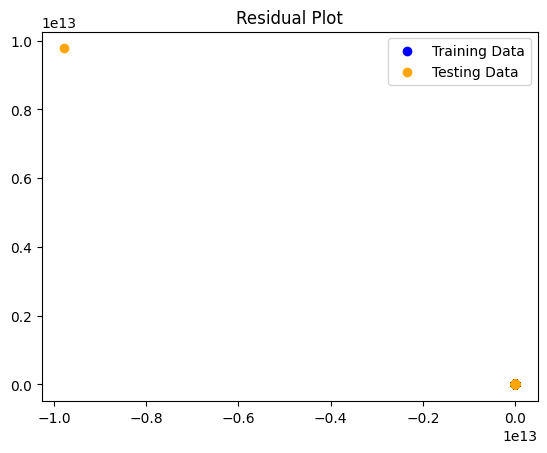

In [342]:
 # Make predictions using a fitted model
# Plot the difference between the model predicted values and actual y values, versus the model predicted values
# Hint: You can predict values of X training and testing data using the model.predict() method on a fitted model

### BEGIN SOLUTION
predictions = model.predict(X_test_scaled)
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), y_train_scaled - model.predict(X_train_scaled), c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), y_test_scaled - model.predict(X_test_scaled), c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()
### END SOLUTION

In [343]:
 # Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2

### BEGIN SOLUTION
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 5.845764163269598e+21, R2: -1.9896388431524635e+26


In [344]:
 # LASSO model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Lasso

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = lasso.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = lasso.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.0008513862752335561, R2: -27.977412643074068


In [345]:
 # Ridge model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = ridge.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = ridge.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.002768140822165175, R2: -93.21523601142624


In [346]:
 # ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = elasticnet.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = elasticnet.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.001561541083979291, R2: -52.147932572871305
